In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gc

from sklearn.metrics import roc_auc_score, log_loss
from functools import partial
from tqdm.notebook import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from scipy.stats import norm
from scipy.special import logit

In [2]:
PATH = '/kaggle/input/ad-clicks/data.csv'
data = pd.read_csv(PATH)

Датасет состоит из показов рекламы.

- date_time - время показа рекламы
- oaid_hash - хэш юзера
- zone_id - id зоны, где зона - место на сайте для размещения рекламы
- banner_id - id баннера, где баннер - сама реклама
- os_id - id операционной системы
- country_id - id страны
- banner_id0 - нулевой баннер в “стакане” баннеров
- banner_id1 - перый баннер в “стакане” баннеров
- rate0 - стоимость 1 клика установленная рекламодателем для banner_id0
- rate1 - стоимость 1 клика установленная рекламодателем для banner_id1
- g0 - стандартное отклонение предикта с banner_id0
- g1 - стандартное отклонение предикта с banner_id1
- coeff_sum0 - сумма коэффициентов для banner_id0
- coeff_sum1 - сумма коэффициентов для banner_id1
- impressions - был ли показ
- clicks - был ли клик


Для Домашней работы 4, колонка campaign_clicks не нужна.

Важный момент. Те предикты которые у вас уже имеются, они работают для banner_id0, потому что он совпадает с banner_id. Но вам еще нужно получить предикты для banner_id1. Для этого следует подставить в тест сете вместо banner_id значение banner_id1.

In [3]:
print(f"unique impressions: {len(data['impressions'].unique())}\n") # impressions все равны 1, их нет смысла брать

unique impressions: 1



In [4]:
data['date_time'] = pd.to_datetime(data['date_time'])

<Axes: xlabel='date_time'>

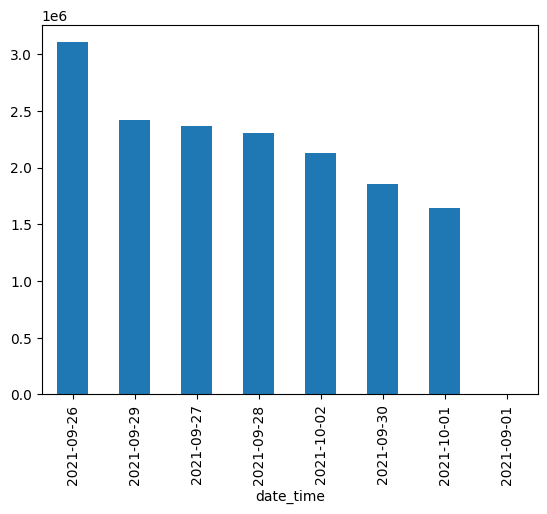

In [5]:
data['date_time'].dt.date.value_counts().plot(kind='bar')

Выброс -- 2021-09-01. Удалим его

In [6]:
data = data[data['date_time'].dt.date != pd.Timestamp('2021-09-01').date()]

In [7]:
# Вытащим используемые фичи

data = data[
    [
        'oaid_hash',
        'date_time',
        'zone_id',
        'os_id',
        'banner_id',
        'country_id',
        'banner_id0',
        'banner_id1',
        'g0',
        'g1',
        'coeff_sum0',
        'coeff_sum1',
        'clicks'
    ]
]
data.head()

,oaid_hash,date_time,zone_id,os_id,banner_id,country_id,banner_id0,banner_id1,g0,g1,coeff_sum0,coeff_sum1,clicks
0,5664530014561852622,2021-09-27 00:01:30,0,0,0,0,1240,0,0.035016,0.049516,-7.268846,-5.369901,1
1,5186611064559013950,2021-09-26 22:54:49,1,0,1,1,1,269,0.054298,0.031942,-2.657477,-4.449220,1
2,2215519569292448030,2021-09-26 23:57:20,2,0,2,0,2,21,0.014096,0.014906,-3.824875,-3.939309,1
3,6262169206735077204,2021-09-27 00:04:30,3,1,3,1,3,99,0.015232,0.050671,-3.461357,-3.418403,1
4,4778985830203613115,2021-09-27 00:06:21,4,1,4,0,4,11464230,0.051265,0.032005,-4.009026,-2.828797,1


In [8]:
# переведем даты в часы, переведем все числовые данные в тип, который занимает меньший объем памяти
# по сравнению с первой дз убрал номера дней, поскольку у нас данные ограничены одной неделей
numeric_cols = ['zone_id', 'os_id', 'banner_id', 'country_id']
data[numeric_cols] = data[numeric_cols].astype('int16')
data['date_time'] = pd.to_datetime(data['date_time'])
data['hour'] = data['date_time'].dt.hour.astype('int16')

Перед анализом данных уберем тестовую выборку

In [9]:
# разделим данные на трейн и тест
max_date = data['date_time'].dt.date.max()
test_data = data[data['date_time'].dt.date == max_date].drop(columns=['date_time'])
train_data = data[data['date_time'].dt.date < max_date]
# разделим треновую выборку
y_train = train_data['clicks'].to_numpy()
train_data = train_data.drop('clicks', axis=1)

gc.collect()

67

In [10]:
# посмотртим на nan'ы
print(test_data.isnull().sum(axis = 0))

oaid_hash        0
zone_id          0
os_id            0
banner_id        0
country_id       0
banner_id0       0
banner_id1       0
g0              12
g1            4904
coeff_sum0      12
coeff_sum1    4904
clicks           0
hour             0
dtype: int64


In [11]:
# удалим nan'ы и строки с banner_id != banner_id0 из теста
# и разделим тестовую выборку
# вытащим колонки для подсчета ipc
test_data = test_data.dropna()
test_data = test_data[test_data['banner_id'] == test_data['banner_id0']]
test_data_replaced = test_data.copy()
test_data_replaced['banner_id'] = test_data_replaced['banner_id1']

y_test = test_data['clicks'].to_numpy()
test_data = test_data.drop('clicks', axis=1)

coeff_sum0 = test_data['coeff_sum0']
coeff_sum1 = test_data['coeff_sum1']
g0 = test_data['g0']
g1 = test_data['g1']

In [12]:
# добавим интеракции
def concat_features(row, column1, column2):
    return ",".join([str(row[column1]), str(row[column2])])

def interactions(data, pair):
    column1, column2 = pair
    concat_function = partial(concat_features, column1=column1, column2=column2)
    column_name = ", ".join(pair)
    data[column_name] = data.apply(concat_function, axis=1)
    return data

def build_interactions(data, interactions_list):
    for pair in tqdm(interactions_list):
        data = interactions(data, pair)
    return data

In [13]:
new_features = [
    ["banner_id", "hour"],
    ["banner_id", "country_id"],
    ["banner_id", "os_id"]
]

train_data = build_interactions(train_data, new_features)

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
test_data = build_interactions(test_data, new_features)

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
test_data_replaced = build_interactions(test_data_replaced, new_features)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# обучим энкодер на трейне и применим его ко всем данным
# вытащим категориальные фичи
categorical_features = [
    'zone_id',
    'os_id',
    'banner_id',
    'country_id',
    'banner_id0',
    'banner_id1',
    'hour',
    'oaid_hash',
    'banner_id, hour',
    'banner_id, country_id',
    'banner_id, os_id'
]
encoder = OneHotEncoder(sparse=True, drop='first', handle_unknown='ignore').fit(train_data[categorical_features])

In [ ]:
train_data = encoder.transform(train_data[categorical_features])
test_data = encoder.transform(test_data[categorical_features])
test_data_replaced = encoder.transform(test_data_replaced[categorical_features])

In [ ]:
# обучим модель из первого дз
clf = LogisticRegression(
    C=0.5502263774188522,
    random_state=3141, 
    solver='liblinear',
    verbose=1,
)

In [ ]:
clf.fit(train_data, y_train)

In [25]:
predict_proba = clf.predict_proba(test_data)
print(f"auc: {roc_auc_score(y_test, predict_proba[:, 1])}")
print(f"log_loss: {log_loss(y_test, predict_proba)}")

auc: 0.8005885872856671
log_loss: 0.13155260422286924


#### CIPS

Оценим вероятность $P(x > y) = P(x - y > 0) = 1 - F_{x - y}(0)$, $x \sim N(\mu_1, \sigma^2_1), y \sim N(\mu_2, \sigma^2_2)$ -- независимые сл. величины из нормальных распределений.  
$F$ -- функция распределения. Откуда $x - y \sim N(\mu_1 - \mu_2, \sigma^2_1 + \sigma^2_2)$.


In [26]:
def get_probs(coeff_sum0, coeff_sum1, g0, g1):
    scale = np.sqrt(g0 ** 2 + g1 ** 2) + 1e-9
    loc = coeff_sum0 - coeff_sum1
    return 1 - norm.cdf(0, loc=loc, scale=scale)

In [34]:
scores_1 = get_probs(coeff_sum0, coeff_sum1, g0, g1)

y_pred_0 = clf.predict_proba(test_data)
y_pred_1 = clf.predict_proba(test_data_replaced)
coeff_sum0_1 = logit(y_pred_0[:, 1])
coeff_sum1_1 = logit(y_pred_1[:, 1])

scores_2 = get_probs(coeff_sum0_1, coeff_sum1_1, g0, g1)

In [36]:
cips = np.mean(y_test * np.minimum(scores_2 / (scores_1 + 1e-9), 10))
print(f"CIPS: {cips}")

CIPS: 0.0626245822127152
